In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

WORKSPACE_PATH = "/content/gdrive/MyDrive/workspace"
DATA_PATH = "/content/gdrive/MyDrive/data"
DATA_CITY_PATH = "/content/gdrive/MyDrive/data/citys"
DATA_GTA_PATH = "/content/gdrive/MyDrive/data/gta"

ROOT_PATH = "/content/gdrive/MyDrive/Colab Notebooks/SSL-Synthetic-Segmentation/Seg-Uncertainty/"

# in terminal
# cd gdrive/MyDrive/workspace

import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/SSL-Synthetic-Segmentation/Seg-Uncertainty')

class CONSTS:
    # cityscapes
    CITYSCAPES_PATH             = DATA_CITY_PATH
    CITYSCAPES_BASE_LIST_PATH   = ROOT_PATH + 'dataset/cityscapes_list/'
    CITYSCAPES_TRAIN_LIST_PATH  = CITYSCAPES_BASE_LIST_PATH + 'train.txt'
    CITYSCAPES_VAL_LIST_PATH    = CITYSCAPES_BASE_LIST_PATH + 'val.txt'
    CITYSCAPES_RESULT_PATH      = ROOT_PATH + "result/cityscapes"
    CITYSCAPES_PSEUDO_PATH      = DATA_CITY_PATH + '/pseudo/'

    # GTA
    GTA_PATH                    = DATA_GTA_PATH
    GTA_TRAIN_LIST_PATH         = ROOT_PATH + 'dataset/gta5_list/train.txt'
    GTA_RESULT_PATH             = ROOT_PATH + 'result/GTA5'

    # Synthia
    SYNTHIA_PATH                = '/data/synthia/'
    SYNTHIA_TRAIN_LIST_PATH     = './dataset/synthia_list/train.txt'

import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!pip install tensorboardX

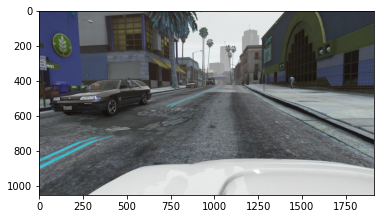

In [3]:
img = cv2.imread("/content/gdrive/MyDrive/data/gta/images/05622.png")
plt.imshow(img)

In [4]:
import torch
import torch.nn as nn
from torch.utils import data, model_zoo
import numpy as np
import pickle
from torch.autograd import Variable
import torch.optim as optim
import scipy.misc
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys
import os
import os.path as osp
import random
import time
import yaml
import easydict
from tensorboardX import SummaryWriter

from trainer_ms import AD_Trainer
from utils.loss import CrossEntropy2d
from utils.tool import adjust_learning_rate, adjust_learning_rate_D, Timer 
from dataset.gta5_dataset import GTA5DataSet
from dataset.cityscapes_dataset import cityscapesDataSet

IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)

AUTOAUG = False
AUTOAUG_TARGET = False

MODEL = 'DeepLab'
BATCH_SIZE = 2
ITER_SIZE = 1
NUM_WORKERS = 2
DATA_DIRECTORY = CONSTS.GTA_PATH
DATA_LIST_PATH = CONSTS.GTA_TRAIN_LIST_PATH
DROPRATE = 0.1
IGNORE_LABEL = 255
INPUT_SIZE = '1280,720'
DATA_DIRECTORY_TARGET = CONSTS.CITYSCAPES_PATH
DATA_LIST_PATH_TARGET = CONSTS.CITYSCAPES_TRAIN_LIST_PATH
INPUT_SIZE_TARGET = '1024,512'
CROP_SIZE = '384,192' # 640,360
LEARNING_RATE = 2.e-4
MOMENTUM = 0.9
MAX_VALUE = 2
NUM_CLASSES = 19
NUM_STEPS = 100000
NUM_STEPS_STOP = 100000  # early stopping
POWER = 0.9
RANDOM_SEED = 1234
RESTORE_FROM = 'http://vllab.ucmerced.edu/ytsai/CVPR18/DeepLab_resnet_pretrained_init-f81d91e8.pth'
SAVE_NUM_IMAGES = 2
SAVE_PRED_EVERY = 1000
SNAPSHOT_DIR = './snapshots/'
WEIGHT_DECAY = 0.0005
WARM_UP = 1000 # no warmup
LOG_DIR = './log'

LEARNING_RATE_D = 1e-4
LAMBDA_SEG = 0.2
LAMBDA_ADV_TARGET1 = 0.0002
LAMBDA_ADV_TARGET2 = 0.001

LAMBDA_ME_TARGET = 0
LAMBDA_KL_TARGET = 0.1

TARGET = 'cityscapes'
SET = 'train'
NORM_STYLE = 'bn' # or in

def get_arguments():
    """Parse all the arguments provided from the CLI.

    Returns:
      A list of parsed arguments.
    """
    args = easydict.EasyDict({
        "autoaug": False,
        "autoaug_target": False,
        "model": MODEL,
        "batch_size": BATCH_SIZE,
        "iter_size": ITER_SIZE,
        "num_workers": NUM_WORKERS,
        "data_dir": DATA_DIRECTORY,
        "data_list": DATA_LIST_PATH,
        "droprate": DROPRATE,
        "ignore_label": IGNORE_LABEL,
        "input_size": INPUT_SIZE,
        "crop_size": CROP_SIZE,
        "data_dir_target": DATA_DIRECTORY_TARGET,
        "data_list_target": DATA_LIST_PATH_TARGET,
        "input_size_target": INPUT_SIZE_TARGET,
        "is_training": False,
        "learning_rate": LEARNING_RATE, # Base learning rate for training with polynomial decay.
        "learning_rate_D": LEARNING_RATE_D, # Base learning rate for discriminator
        "lambda_seg": LAMBDA_SEG,
        "lambda_adv_target1": LAMBDA_ADV_TARGET1,
        "lambda_adv_target2": LAMBDA_ADV_TARGET2,
        "lambda_me_target": LAMBDA_ME_TARGET,
        "lambda_kl_target":LAMBDA_KL_TARGET,
        "momentum": MOMENTUM,
        "max_value": MAX_VALUE,
        "norm_style": NORM_STYLE,
        "lambda_me_target": LAMBDA_ME_TARGET,
        "lambda_kl_target": LAMBDA_KL_TARGET,
        "momentum": MOMENTUM,
        "max_value": MAX_VALUE,
        "norm_style": NORM_STYLE,
        "not_restore_last": False,
        "num_classes": NUM_CLASSES,
        "num_steps": NUM_STEPS,
        "num_steps_stop": NUM_STEPS_STOP,
        "power": POWER,
        "random_mirror": False,
        "random_scale": False,
        "fp16": False,
        "random_seed": RANDOM_SEED,
        "restore_from": RESTORE_FROM,
        "save_num_images": SAVE_NUM_IMAGES,
        "save_pred_every": SAVE_PRED_EVERY,
        "snapshot_dir": SNAPSHOT_DIR,
        "weight_decay": WEIGHT_DECAY,
        "warm_up": WARM_UP,
        "cpu": False,
        "class_balance": False,
        "use_se": True,
        "only_hard_label": 0,
        "train_bn": False,
        "sync_bn": False,
        "often_balance": True,
        "gpu_ids": '0',
        "tensorboard": True,
        "log_dir": LOG_DIR,
        "set": SET,
        "multi_gpu": False,
        "snapshot_dir": SNAPSHOT_DIR,
    })   

    return args


args = get_arguments()

# save opts
if not os.path.exists(args.snapshot_dir):
    os.makedirs(args.snapshot_dir)

with open('%s/opts.yaml'%args.snapshot_dir, 'w') as fp:
    yaml.dump(vars(args), fp, default_flow_style=False)


def main():
    """Create the model and start the training."""

    w, h = map(int, args.input_size.split(','))
    args.input_size = (w, h)

    w, h = map(int, args.crop_size.split(','))
    args.crop_size = (h, w)

    w, h = map(int, args.input_size_target.split(','))
    args.input_size_target = (w, h)

    cudnn.enabled = True
    cudnn.benchmark = True


    str_ids = args.gpu_ids.split(',')
    gpu_ids = []
    for str_id in str_ids:
        gid = int(str_id)
        if gid >=0:
            gpu_ids.append(gid)

    num_gpu = len(gpu_ids)

    if num_gpu>1:
        args.multi_gpu = True
        Trainer = AD_Trainer(args)
        Trainer.G = torch.nn.DataParallel( Trainer.G, gpu_ids)
        Trainer.D1 = torch.nn.DataParallel( Trainer.D1, gpu_ids)
        Trainer.D2 = torch.nn.DataParallel( Trainer.D2, gpu_ids)
    else:
        Trainer = AD_Trainer(args)

    print(Trainer)

    trainloader = data.DataLoader(
        GTA5DataSet(args.data_dir, args.data_list, max_iters=args.num_steps * args.iter_size * args.batch_size,
                    resize_size=args.input_size,
                    crop_size=args.crop_size,
                    scale=True, mirror=True, mean=IMG_MEAN, autoaug = args.autoaug),
        batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True, drop_last=True)

    trainloader_iter = enumerate(trainloader)

    targetloader = data.DataLoader(cityscapesDataSet(args.data_dir_target, args.data_list_target,
                                                     max_iters=args.num_steps * args.iter_size * args.batch_size,
                                                     resize_size=args.input_size_target,
                                                     crop_size=args.crop_size,
                                                     scale=False, mirror=args.random_mirror, mean=IMG_MEAN,
                                                     set=args.set, autoaug = args.autoaug_target),
                                   batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers,
                                   pin_memory=True, drop_last=True)


    targetloader_iter = enumerate(targetloader)

    # set up tensor board
    if args.tensorboard:
        args.log_dir += '/'+ os.path.basename(args.snapshot_dir)
        if not os.path.exists(args.log_dir):
            os.makedirs(args.log_dir)

        writer = SummaryWriter(args.log_dir)

    for i_iter in range(args.num_steps):

        loss_seg_value1 = 0
        loss_adv_target_value1 = 0
        loss_D_value1 = 0

        loss_seg_value2 = 0
        loss_adv_target_value2 = 0
        loss_D_value2 = 0


        adjust_learning_rate(Trainer.gen_opt , i_iter, args)
        adjust_learning_rate_D(Trainer.dis1_opt, i_iter, args)
        adjust_learning_rate_D(Trainer.dis2_opt, i_iter, args)

        for sub_i in range(args.iter_size):

            # train G

            # train with source

            _, batch = trainloader_iter.__next__()
            _, batch_t = targetloader_iter.__next__()

            images, labels, _, _ = batch
            images = images.cuda()
            labels = labels.long().cuda()
            images_t, labels_t, _, _ = batch_t
            images_t = images_t.cuda()
            labels_t = labels_t.long().cuda()

            with Timer("Elapsed time in update: %f"):
                loss_seg1, loss_seg2, loss_adv_target1, loss_adv_target2, loss_me, loss_kl, pred1, pred2, pred_target1, pred_target2, val_loss = Trainer.gen_update(images, images_t, labels, labels_t, i_iter)
                loss_seg_value1 += loss_seg1.item() / args.iter_size
                loss_seg_value2 += loss_seg2.item() / args.iter_size
                loss_adv_target_value1 += loss_adv_target1 / args.iter_size
                loss_adv_target_value2 += loss_adv_target2 / args.iter_size
                loss_me_value = loss_me

                if args.lambda_adv_target1 > 0 and args.lambda_adv_target2 > 0:
                    loss_D1, loss_D2 = Trainer.dis_update(pred1, pred2, pred_target1, pred_target2)
                    loss_D_value1 += loss_D1.item()
                    loss_D_value2 += loss_D2.item()
                else:
                    loss_D_value1 = 0
                    loss_D_value2 = 0

        del pred1, pred2, pred_target1, pred_target2

        if args.tensorboard:
            scalar_info = {
                'loss_seg1': loss_seg_value1,
                'loss_seg2': loss_seg_value2,
                'loss_adv_target1': loss_adv_target_value1,
                'loss_adv_target2': loss_adv_target_value2,
                'loss_me_target': loss_me_value,
                'loss_kl_target': loss_kl,
                'loss_D1': loss_D_value1,
                'loss_D2': loss_D_value2,
                'val_loss': val_loss,
            }

            if i_iter % 100 == 0:
                for key, val in scalar_info.items():
                    writer.add_scalar(key, val, i_iter)

        print('exp = {}'.format(args.snapshot_dir))
        print(
        '\033[1m iter = %8d/%8d \033[0m loss_seg1 = %.3f loss_seg2 = %.3f loss_me = %.3f  loss_kl = %.3f loss_adv1 = %.3f, loss_adv2 = %.3f loss_D1 = %.3f loss_D2 = %.3f, val_loss=%.3f'%(i_iter, args.num_steps, loss_seg_value1, loss_seg_value2, loss_me_value, loss_kl, loss_adv_target_value1, loss_adv_target_value2, loss_D_value1, loss_D_value2, val_loss))

        # clear loss
        del loss_seg1, loss_seg2, loss_adv_target1, loss_adv_target2, loss_me, loss_kl, val_loss

        if i_iter >= args.num_steps_stop - 1:
            print('save model ...')
            torch.save(Trainer.G.state_dict(), osp.join(args.snapshot_dir, 'GTA5_' + str(args.num_steps_stop) + '.pth'))
            torch.save(Trainer.D1.state_dict(), osp.join(args.snapshot_dir, 'GTA5_' + str(args.num_steps_stop) + '_D1.pth'))
            torch.save(Trainer.D2.state_dict(), osp.join(args.snapshot_dir, 'GTA5_' + str(args.num_steps_stop) + '_D2.pth'))
            break

        if i_iter % args.save_pred_every == 0 and i_iter != 0:
            print('taking snapshot ...')
            torch.save(Trainer.G.state_dict(), osp.join(args.snapshot_dir, 'GTA5_' + str(i_iter) + '.pth'))
            torch.save(Trainer.D1.state_dict(), osp.join(args.snapshot_dir, 'GTA5_' + str(i_iter) + '_D1.pth'))
            torch.save(Trainer.D2.state_dict(), osp.join(args.snapshot_dir, 'GTA5_' + str(i_iter) + '_D2.pth'))

    if args.tensorboard:
        writer.close()



This is not an error. If you want to use low precision, i.e., fp16, please install the apex with cuda support (https://github.com/NVIDIA/apex) and update pytorch to 1.0


In [5]:
main()

['conv1', 'weight'] is loaded from pre-trained weight.

['bn1', 'weight'] is loaded from pre-trained weight.

['bn1', 'bias'] is loaded from pre-trained weight.

['bn1', 'running_mean'] is loaded from pre-trained weight.

['bn1', 'running_var'] is loaded from pre-trained weight.

['layer1', '0', 'conv1', 'weight'] is loaded from pre-trained weight.

['layer1', '0', 'bn1', 'weight'] is loaded from pre-trained weight.

['layer1', '0', 'bn1', 'bias'] is loaded from pre-trained weight.

['layer1', '0', 'bn1', 'running_mean'] is loaded from pre-trained weight.

['layer1', '0', 'bn1', 'running_var'] is loaded from pre-trained weight.

['layer1', '0', 'conv2', 'weight'] is loaded from pre-trained weight.

['layer1', '0', 'bn2', 'weight'] is loaded from pre-trained weight.

['layer1', '0', 'bn2', 'bias'] is loaded from pre-trained weight.

['layer1', '0', 'bn2', 'running_mean'] is loaded from pre-trained weight.

['layer1', '0', 'bn2', 'running_var'] is loaded from pre-trained weight.

['layer

/usr/local/lib/python3.7/dist-packages/torch/optim/sgd.py:69: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(SGD, self).__init__(params, defaults)
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


AD_Trainer(
  (G): ResNetMulti(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Streaming output truncated to the last 5000 lines.
GTA5: Too young too naive for 7 times!
GTA5: Too young too naive for 8 times!
GTA5: Too young too naive for 9 times!
Elapsed time in update: 2.426338
exp = ./snapshots/
 iter =      191/  100000  loss_seg1 = 2.538 loss_seg2 = 1.246 loss_me = 0.000  loss_kl = 0.000 loss_adv1 = 3.251, loss_adv2 = 1.692 loss_D1 = 0.744 loss_D2 = 1.584, val_loss=1.311
-------lr_G: 0.000055-------
(3, 579, 1029) (579, 1029)
GTA5: Too young too naive for 0 times!
GTA5: Too young too naive for 1 times!
(3, 645, 1146) (645, 1146)
GTA5: Too young too naive for 0 times!
GTA5: Too young too naive for 1 times!
GTA5: Too young too naive for 2 times!
GTA5: Too young too naive for 3 times!
GTA5: Too young too naive for 4 times!
GTA5: Too young too naive for 5 times!
(3, 803, 1427) (803, 1427)
GTA5: Too young too naive for 0 times!
GTA5: Too young too naive for 1 times!
GTA5: Too young too naive for 2 times!
GTA5: Too young too naive for 3 times!
GTA5: Too young too n

KeyboardInterrupt: ignored

In [33]:
!nvidia-smi

Sat Sep 11 09:25:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    74W / 149W |  11371MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------